# StarDist Nucleus Segmentation

by [Qin Yu](https://github.com/qin-yu), Apr 2022

In [1]:
# Restrict Jupyter notebook to a single graphics card:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [22]:
from cellpose import models, core
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [3]:
core.use_gpu()

True

In [6]:
path_image_input = "/g/kreshuk/yu/Datasets/CPape2020COVID/train/gt_image_007.h5"
with h5py.File(path_image_input, 'r') as f_in:
    raw_nuclei = f_in['raw/nuclei'][:]

In [4]:
model = models.Cellpose(gpu=True, model_type="nuclei", omni=False)

In [8]:
masks, flows, styles, diams = model.eval(raw_nuclei, diameter=None, flow_threshold=0.3, channels=[0, 0])


In [15]:
def render_label(lbl, img = None, cmap = None, cmap_img = "gray", alpha = 0.5, alpha_boundary = None, normalize_img = True):
    """Renders a label image and optionally overlays it with another image. Used for generating simple output images to asses the label quality

    Parameters
    ----------
    lbl: np.ndarray of dtype np.uint16
        The 2D label image 
    img: np.ndarray 
        The array to overlay the label image with (optional)
    cmap: string, tuple, or callable
        The label colormap. If given as rgb(a)  only a single color is used, if None uses a random colormap 
    cmap_img: string or callable
        The colormap of img (optional)
    alpha: float 
        The alpha value of the overlay. Set alpha=1 to get fully opaque labels
    alpha_boundary: float
        The alpha value of the boundary (if None, use the same as for labels, i.e. no boundaries are visible)
    normalize_img: bool
        If True, normalizes the img (if given)

    Returns
    -------
    img: np.ndarray
        the (m,n,4) RGBA image of the rendered label 

    Example
    -------

    from scipy.ndimage import label, zoom      
    img = zoom(np.random.uniform(0,1,(16,16)),(8,8),order=3)            
    lbl,_ = label(img>.8)
    u1 = render_label(lbl, img = img, alpha = .7)
    u2 = render_label(lbl, img = img, alpha = 0, alpha_boundary =.8)
    plt.subplot(1,2,1);plt.imshow(u1)
    plt.subplot(1,2,2);plt.imshow(u2)

    """
    from skimage.segmentation import find_boundaries
    from matplotlib import cm
    
    alpha = np.clip(alpha, 0, 1)

    if alpha_boundary is None:
        alpha_boundary = alpha
        
    if cmap is None:
        cmap = random_label_cmap()
    elif isinstance(cmap, tuple):
        cmap = _single_color_integer_cmap(cmap)
    else:
        pass
        
    cmap = cm.get_cmap(cmap) if isinstance(cmap, str) else cmap
    cmap_img = cm.get_cmap(cmap_img) if isinstance(cmap_img, str) else cmap_img

    # render image if given
    if img is None:
        im_img = np.zeros(lbl.shape+(4,),np.float32)
        im_img[...,-1] = 1
        
    else:
        assert lbl.shape[:2] == img.shape[:2]
        img = normalize(img) if normalize_img else img
        if img.ndim==2:
            im_img = cmap_img(img)
        elif img.ndim==3:
            im_img = img[...,:4]
            if img.shape[-1]<4:
                im_img = np.concatenate([img, np.ones(img.shape[:2]+(4-img.shape[-1],))], axis = -1)
        else:
            raise ValueError("img should be 2 or 3 dimensional")
            
                
            
    # render label
    im_lbl = cmap(lbl)

    mask_lbl = lbl>0
    mask_bound = np.bitwise_and(mask_lbl,find_boundaries(lbl, mode = "thick"))
    
    # blend
    im = im_img.copy()
    
    im[mask_lbl] = alpha*im_lbl[mask_lbl]+(1-alpha)*im_img[mask_lbl]
    im[mask_bound] = alpha_boundary*im_lbl[mask_bound]+(1-alpha_boundary)*im_img[mask_bound]
        
    return im

In [19]:
def random_label_cmap(n=2**16, h = (0,1), l = (.4,1), s =(.2,.8)):
    import matplotlib
    import colorsys
    # cols = np.random.rand(n,3)
    # cols = np.random.uniform(0.1,1.0,(n,3))
    h,l,s = np.random.uniform(*h,n), np.random.uniform(*l,n), np.random.uniform(*s,n)
    cols = np.stack([colorsys.hls_to_rgb(_h,_l,_s) for _h,_l,_s in zip(h,l,s)],axis=0)
    cols[0] = 0
    return matplotlib.colors.ListedColormap(cols)

Text(0.5, 1.0, 'prediction')

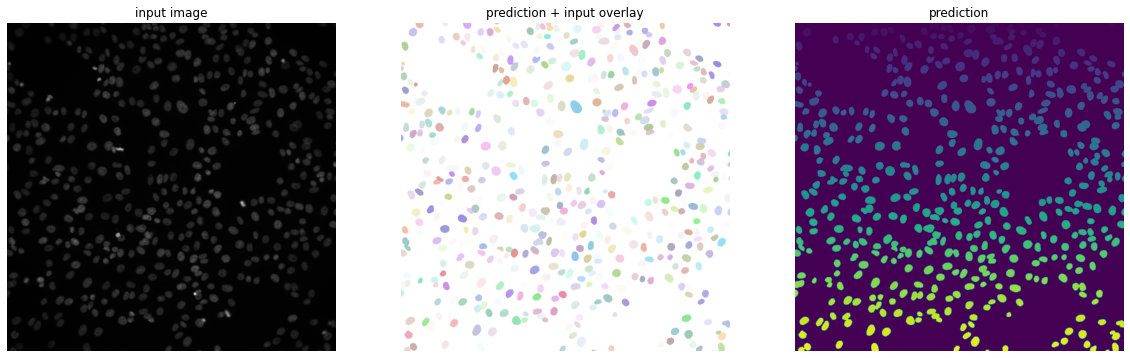

In [21]:
plt.figure(figsize=(20, 15))

plt.subplot(1,3,1)
plt.imshow(raw_nuclei, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,3,2)
plt.imshow(render_label(masks, img=raw_nuclei, normalize_img=False))
plt.axis("off")
plt.title("prediction + input overlay")

plt.subplot(1,3,3)
plt.imshow(masks)
plt.axis("off")
plt.title("prediction")